# Model validation

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)
# from jax.config import config; config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util, pmap
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Model Validation")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


## Render model

# CONFIG
{'mesh_size': array([128, 128, 128]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.1, 'a_obs': 0.5, 'lpt_order': 2, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_meshes': True, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0], 'init_mesh': ['{\\delta}_L', None, None]}, 'fourier': False, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [5.0, 5.0, 5.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.62832 h/Mpc
mean_gxy_density: 0.125 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

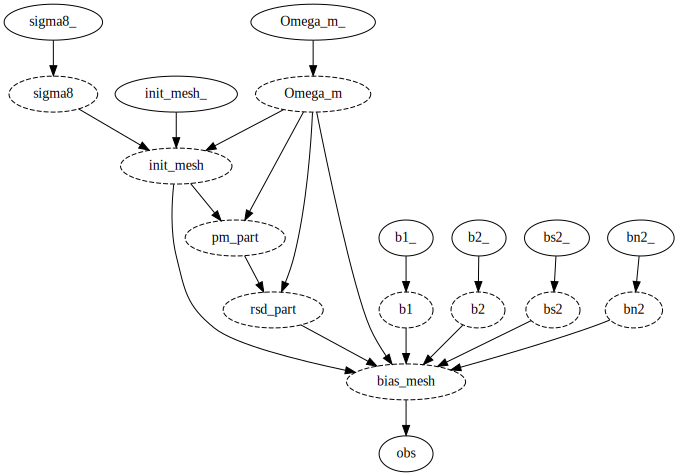

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn, get_cosmology
from montecosmo.models import print_config, get_prior_loc, default_config as config
# Build and render model
config.update(a_lpt=0.1, a_obs=0.5, mesh_size=128*np.ones(3, dtype=int), box_size=640*np.ones(3), 
            #   trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
              trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
# config['prior_config']['b2'][1] = 0
# config['prior_config']['b1'][1] =8 1
model = partial(pmrsd_model, **config)
print_config(model)
numpyro.render_model(model=model, render_params=True) # filename="model_DAG.png"

## Simulate fiducial

In [3]:
# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_loc(model)))
fiduc_simulator = get_simulator(fiduc_model)
fiduc_trace = fiduc_simulator(0, dict(a_lpt=0.5, lpt_order=1, trace_meshes=1))
fiduc_trace2 = fiduc_simulator(0, dict(a_lpt=0.5, lpt_order=2, trace_meshes=1))
fiduc_trace_pm = fiduc_simulator(0, dict(a_lpt=0.1, lpt_order=1, trace_meshes=10))
fiduc_cosmo = get_cosmology(**fiduc_trace)
print(f"Fiducial {fiduc_cosmo}")

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


1


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

2


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

1


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 4
Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2621 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


## Power spectra

In [4]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get and vectorize relevant functionals
multipoles = [0,2,4]
pk_fn = get_pk_fn(multipoles=multipoles, **config)

# Get meshes from model trace particles. Must compensate for CIC painting convolution
zeros_mesh = jnp.zeros(config['mesh_size'])
pm_mesh_pm = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace_pm['pm_part'][:,0])
pm_mesh2 = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace2['pm_part'][:,0])
pm_mesh = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace['pm_part'][:,0])

# Compute power spectra
pk_init = pk_fn(fiduc_trace['init_mesh'])
pk_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh))
pk_pm2 = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh2))
pk_pm_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh_pm))
# pk_obs = pk_fn(compensate_cic(fiduc_trace['obs_mesh']))
pk_lin_init = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo)(pk_init[0])])
pk_lin_obs = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo, a=config['a_obs'])(pk_init[0])])

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

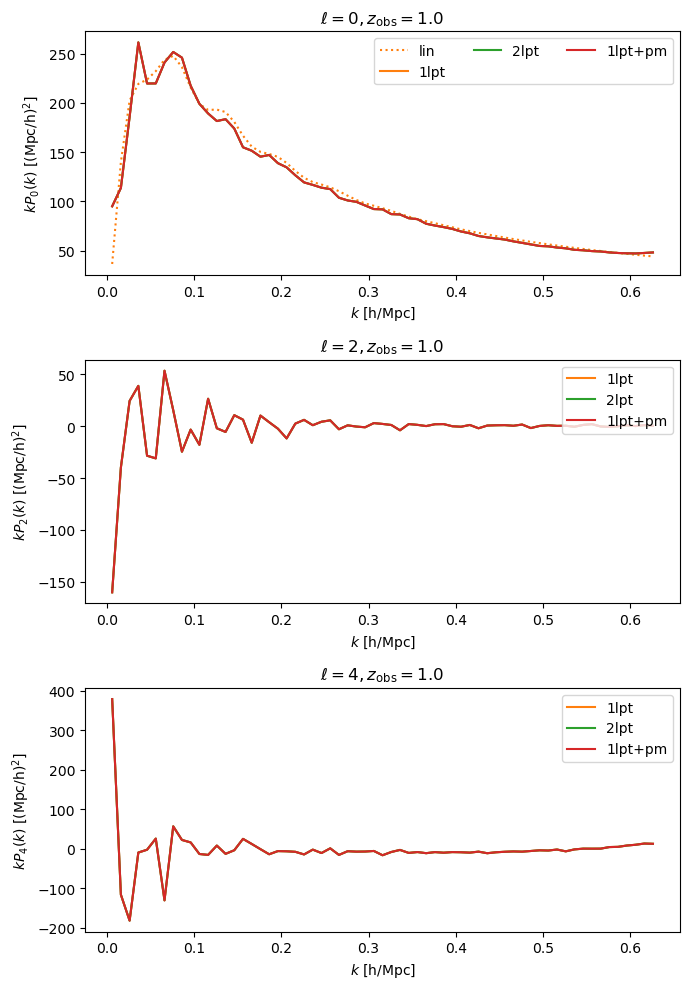

In [ ]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin")
    # if multipole==0:
    #     plot_fn(pk_lin_init, 'C0:', label=f"lin (z={1/1-1:.1f})")

    plot_fn(pk_pm[-1], 'C1', label=f"1lpt")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C1', alpha=0.2)

    plot_fn(pk_pm[-1], 'C2', label=f"2lpt")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C2', alpha=0.2)

    plot_fn(pk_pm[-1], 'C3', label=f"1lpt+pm")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C3', alpha=0.2)
    # plot_fn(pk_init, 'C0', label=f"init (z={1/1-1:.1f})")

    if multipole==0: plt.legend(loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();